# Heart Failure Classification

# Import the needed libraries

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.tree
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,InputLayer
from tensorflow.keras import callbacks
from graphviz import Digraph

# Utility Classes

In [5]:
class ModelEvaluator:
    def __init__(self,model,model_name,color_theme='Blues'):
        self.model = model
        self.model_name = model_name
        self.color_theme = color_theme
        self.y_pred = None
        self.accuracy = None
        self.f1_score = None
        self.conf_matrix = None

    def evaluate(self, X_test, y_test):
        # Evaluate the model on the test set
        self.y_pred = self.model.predict(X_test)

        if isinstance(self.y_pred, list):
            self.y_pred = np.array(self.y_pred)

        self.y_pred = (self.y_pred > 0.5).astype(int)  # binary classification 
        self.accuracy = accuracy_score(y_test,self.y_pred)
        self.f1_score = f1_score(y_test,self.y_pred)
        self.conf_matrix = confusion_matrix(y_test,self.y_pred)
        return self.accuracy,self.f1_score,self.conf_matrix
    
    def evaluate_bagging(self, X_test, y_test):
        y_m_model = []
        y_bagging = []

        for i in range(0, len(self.model)):
            y_m_model.append(self.model[i].predict(X_test))
        
        y_maj_vote = [sum(col) / len(col) for col in zip(*y_m_model)]
        for i in range(0, len(y_maj_vote)):
            if(y_maj_vote[i] > 0.5): y_bagging.append(1)
            else: y_bagging.append(0)
        self.y_pred = y_bagging
        self.accuracy = accuracy_score(y_test, self.y_pred)
        self.f1_score = f1_score(y_test, self.y_pred)
        self.conf_matrix = confusion_matrix(y_test, self.y_pred)
        return self.accuracy,self.f1_score,self.conf_matrix
    
    def plot_confusion_matrix(self,font_size=14,title_font_size=16,annot_font_size=12):
        # Plot the confusion matrix
        plt.figure(figsize=(5,5))
        sns.heatmap(            
            self.conf_matrix,
            annot=True,
            fmt='d',
            cmap=self.color_theme,
            xticklabels=['No heart disease','Heart disease'],
            yticklabels=['No heart disease','Heart disease'],
            annot_kws={"size":annot_font_size,"weight":"bold"},
            cbar_kws={"shrink":0.8}
            )
        plt.xlabel('Predicted',fontsize=font_size,weight='bold')
        plt.ylabel('True',fontsize=font_size,weight='bold')
        plt.title(f'Confusion matrix for {self.model_name}',fontsize=title_font_size,weight='bold',pad=20)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.show()

    def print_metrics(self,y_test):
        # Print evaluation metrics
        print("Model",self.model_name)
        print("Accuracy",self.accuracy)
        print("F1-score:",self.f1_score)
        print("\nClassification report:")
        print(classification_report(y_test,self.y_pred,target_names=['No heart disease','Heart disease']))

    def find_most_confusing_classes(self):
        confusion_matrix2 = self.conf_matrix.copy()
        np.fill_diagonal(confusion_matrix2,0) # because correct predictions are on the diagonal
        most_confusing = np.unravel_index(np.argmax(confusion_matrix2),confusion_matrix2.shape)
        print(f"Most confusing classes: True label {most_confusing[0]} --> predicted as {most_confusing[1]}")

    def summarize(self,X_test,y_test):
        # Runs all evaluation steps and summarize the results
        self.evaluate(X_test,y_test)
        self.print_metrics(y_test)
        self.plot_confusion_matrix()
        self.find_most_confusing_classes()

    def summarize_bagging(self,X_test,y_test):
        # Runs all evaluation steps and summarize the results
        self.evaluate_bagging(X_test,y_test)
        self.print_metrics(y_test)
        self.plot_confusion_matrix()
        self.find_most_confusing_classes()

# Data Preparation Step

In [258]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [259]:
class HeartDiseaseData:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None

    def load_data(self):
        # Load dataset from a CSV file
        self.df = pd.read_csv(self.data_path)
        print("\nSample Data:")
        print(tabulate(self.df.head(), headers='keys', tablefmt='grid'))

    def split_features_target(self, target_column):
        # Split the dataset into features (X) and target (y)
        self.X = self.df.drop(columns=[target_column])
        self.y = self.df[target_column]

    def encode_categorical_columns(self, categorical_columns):
        # Perform one-hot encoding for categorical columns
        self.X = pd.get_dummies(self.X, columns=categorical_columns, dtype='uint8')
        print("\nEncoded Columns:")
        print(tabulate(pd.DataFrame({'Columns': self.X.columns}), headers='keys', tablefmt='grid'))

    def split_train_validation_test(self, train_size=0.7, test_size=0.2, val_size=0.1, random_state=42):
        # Split dataset into training, validation, and test sets while maintaining class distribution
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(
            self.X, self.y, test_size=(1 - train_size), stratify=self.y, random_state=random_state
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            X_temp, y_temp, test_size=(test_size / (test_size + val_size)), stratify=y_temp, random_state=random_state
        )

    def print_class_distribution(self):
        # Split dataset into training, validation, and test sets while maintaining class distribution
        class_dist = {
            'Dataset': ['Training', 'Validation', 'Test'],
            'Class Distribution': [
                self.y_train.value_counts(normalize=True).to_dict(),
                self.y_val.value_counts(normalize=True).to_dict(),
                self.y_test.value_counts(normalize=True).to_dict()
            ]
        }
        print("\nClass Distribution:")
        print(tabulate(pd.DataFrame(class_dist), headers='keys', tablefmt='grid'))

    def standardize_features(self, dataset):
        # Standardize numerical features using StandardScaler
        scaler = StandardScaler()
        self.df_standardized = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
        return self.df_standardized

    def preprocess_data(self, target_column, categorical_columns):
        # Run preprocessing steps
        self.load_data()
        self.split_features_target(target_column)
        self.encode_categorical_columns(categorical_columns)
        self.split_train_validation_test()
        self.print_class_distribution()

In [7]:
data_path = "heart.csv"
target_column = 'HeartDisease'
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Initialize the data processor
data_processor = HeartDiseaseData(data_path)

# Preprocess the data
data_processor.preprocess_data(target_column, categorical_columns)

# Data
X_train = data_processor.X_train
X_val = data_processor.X_val
X_test = data_processor.X_test
y_train = data_processor.y_train
y_val = data_processor.y_val
y_test = data_processor.y_test
df_standardized = data_processor.standardize_features(X_train)
print("\nStandardized Data Sample:")
print(tabulate(df_standardized.head(), headers='keys', tablefmt='grid'))


Sample Data:
+----+-------+-------+-----------------+-------------+---------------+-------------+--------------+---------+------------------+-----------+------------+----------------+
|    |   Age | Sex   | ChestPainType   |   RestingBP |   Cholesterol |   FastingBS | RestingECG   |   MaxHR | ExerciseAngina   |   Oldpeak | ST_Slope   |   HeartDisease |
+====+=======+=======+=================+=============+===============+=============+==============+=========+==================+===========+============+================+
|  0 |    40 | M     | ATA             |         140 |           289 |           0 | Normal       |     172 | N                |       0   | Up         |              0 |
+----+-------+-------+-----------------+-------------+---------------+-------------+--------------+---------+------------------+-----------+------------+----------------+
|  1 |    49 | F     | NAP             |         160 |           180 |           0 | Normal       |     156 | N                |   

In [8]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (642, 20)
y_train shape: (642,)
X_val shape: (92, 20)
y_val shape: (92,)
X_test shape: (184, 20)
y_test shape: (184,)


# ML Classifiers

## Decision Tree

### Building the model

In [9]:
class DecisionTreeNode:
    def __init__(
        self,
        feature: int | None = None,
        threshold: float | None = None,
        predicted_class: int | None = None,
        depth: int | None = None,
        left: "DecisionTreeNode | None" = None,
        right: "DecisionTreeNode | None" = None,
        entropy: float | None = None,
        samples: int = 0,
        values: dict[int, int] | None = None,
        feat_idx: int | None = None,
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.predicted_class = predicted_class
        self.depth = depth
        self.entropy = entropy
        self.values = values
        self.samples = samples
        self.feat_idx = feat_idx

    def __str__(self):
        return (
            f"{self.feature} <= {self.threshold}\n"
            f"Entropy = {self.entropy}\n"
            f"Samples = {self.samples}\n"
            f"Values = {self.values}\n"
            f"Class = {self.predicted_class}\n"
            f"Node Depth = {self.depth}\n"
        )

In [10]:
class DecisionTreeUtils:
    @staticmethod
    def information_gain(y : np.ndarray, y1 : np.ndarray, y2 : np.ndarray) -> float:
        y_entropy = DecisionTreeUtils.entropy(y)
        y_entropy_after_split_1 = DecisionTreeUtils.entropy(y1)
        y_entropy_after_split_2 = DecisionTreeUtils.entropy(y2)
        return (
            y_entropy
            - (len(y1) / len(y)) * y_entropy_after_split_1
            - (len(y2) / len(y)) * y_entropy_after_split_2
        )

    @staticmethod
    def entropy(y : np.ndarray) -> float:
        zeroes_number = (y == 0).sum()
        prob_zero = zeroes_number / len(y)
        prob_one = 1 - prob_zero
        probs = np.array([prob_one, prob_zero])
        return -1 * np.sum(probs * np.log2(np.where(probs == 0, 1, probs)))

In [11]:
class DecisionTreeBuilder:
    def __init__(self, max_depth: int = 4, min_samples_split: int = 1):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.utils = DecisionTreeUtils()

    def build_tree(self, X : np.ndarray, y : np.ndarray, curr_depth : int, columns: list) -> DecisionTreeNode:
        if (curr_depth == self.max_depth or len(set(y)) <= 1 or (self.min_samples_split is not None and self.min_samples_split > len(y))):
            return DecisionTreeNode(values= dict(Counter(y)), samples= len(y), entropy= round(self.utils.entropy(y), 3), predicted_class=Counter(y).most_common(1)[0][0], depth=curr_depth)

        feature, threshold = self._best_split(X, y)
        tree_node = DecisionTreeNode(values= dict(Counter(y)), samples= len(y), entropy= round(self.utils.entropy(y), 3), feature= columns[feature],threshold=threshold,depth=curr_depth, feat_idx= feature)

        mask = X[:, feature] <= threshold
        X_left_split = X[mask, :]
        y_left_split = y[mask]
        X_right_split = X[~mask, :]
        y_right_split = y[~mask]

        tree_node.left = self.build_tree(X_left_split, y_left_split, curr_depth + 1, columns)
        tree_node.right = self.build_tree(X_right_split, y_right_split, curr_depth + 1, columns)
        return tree_node

    def traverse_tree(self, x : np.ndarray, node : DecisionTreeNode) -> int: # returns a class (0/1)
        if node.predicted_class is not None:
            return node.predicted_class
        return self.traverse_tree(x, node.left) if x[node.feat_idx] <= node.threshold else self.traverse_tree(x, node.right)

    def _best_split(self, X : np.ndarray, y : np.ndarray) -> tuple[int, int]: # feature and thresold are integers
        unique_values_list = [np.unique(X[:, i]) for i in range(X.shape[1])]
        mid_points_list = [values[:-1] + np.diff(values) / 2 for values in unique_values_list]

        max_info_gain = {"infoGain": -float("inf"), "feature": -1, "threshold": None}
        for i in range(X.shape[1]):
            local_max_info_gain = { "infoGain": -float("inf"), "feature": -1, "threshold": None}
            for split in mid_points_list[i]:
                mask = X[:, i] <= split
                left_split = y[mask]
                right_split = y[~mask]

                info_gain = self.utils.information_gain(y, left_split, right_split)
                if info_gain > local_max_info_gain["infoGain"]:
                    local_max_info_gain = { "infoGain": info_gain, "feature": i, "threshold": split}

            if local_max_info_gain["infoGain"] > max_info_gain["infoGain"]:
                max_info_gain = local_max_info_gain

        return max_info_gain["feature"], max_info_gain["threshold"]

In [12]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int = 4, min_samples_split: int =10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.builder = DecisionTreeBuilder(min_samples_split=min_samples_split, max_depth=max_depth)

    def fit(self, X : pd.DataFrame, y : pd.Series):
        X_np = X.to_numpy()
        y_np = y.to_numpy()
        self.root = self.builder.build_tree(X_np, y_np, 0, X.columns)

    def predict(self, X : pd.DataFrame) -> list[int]: # classification of each input
        X_np = X.to_numpy()
        predictions_list = [self.builder.traverse_tree(row, self.root) for row in X_np]
        return predictions_list

In [13]:
def plot_tree(model : DecisionTreeClassifier, dot : Digraph):
    def add_edges(node : DecisionTreeNode):
        if node:
            # Label each node with feature, threshold, class, and depth
            dot.node(str(id(node)), label=str(node))

            if node.left:
                dot.edge(str(id(node)), str(id(node.left)), label="T")  # Left child
                add_edges(node.left)
            if node.right:
                dot.edge(str(id(node)), str(id(node.right)), label="F")  # Right child
                add_edges(node.right)

    add_edges(model.root)
    display(dot)

### Tuning Hyperparameters Using the Validation Set

In [14]:
from copy import deepcopy
class HyperParameterTuner:
    def __init__(self, model : DecisionTreeClassifier):
        self.model = model

    def fine_tune(self, X_train : pd.DataFrame, y_train : pd.Series, X_val : pd.DataFrame, y_val : pd.Series, param_grid : dict[list[int], list[int]]) -> None:
        best_accuracy = 0
        best_params = None
        best_model = self.model
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                temp_model = DecisionTreeClassifier(max_depth, min_samples_split)
                temp_model.fit(X_train, y_train)

                y_pred = temp_model.predict(X_val)
                val_accuracy = accuracy_score(y_val, y_pred)
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'max_depth' : max_depth, 'min_samples_split': min_samples_split}
                    best_model = temp_model
                    print("current hyperparameters after fine tuning:", best_params, "accuracy:", best_accuracy)
                    print("---------------------------------------------------------------------------------------")
        return best_model, best_params

In [15]:
model = DecisionTreeClassifier()
fine_tuned_model = HyperParameterTuner(model)
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, None],
    "min_samples_split": [2, 3, 4, 20, 30, 40],
}

best_model, best_params = fine_tuned_model.fine_tune(X_train, y_train, X_val, y_val, param_grid)
max_depth = best_params['max_depth']
min_samples_split = best_params['min_samples_split']
print(f"Fine-tuned to max_depth={max_depth}, min_samples_split={min_samples_split}")

current hyperparameters after fine tuning: {'max_depth': 2, 'min_samples_split': 2} accuracy: 0.8478260869565217
---------------------------------------------------------------------------------------
current hyperparameters after fine tuning: {'max_depth': 3, 'min_samples_split': 2} accuracy: 0.8695652173913043
---------------------------------------------------------------------------------------
current hyperparameters after fine tuning: {'max_depth': 5, 'min_samples_split': 2} accuracy: 0.8804347826086957
---------------------------------------------------------------------------------------
Fine-tuned to max_depth=5, min_samples_split=2


### Evaluating the model

Model Decision Tree
Accuracy 0.8315217391304348
F1-score: 0.8426395939086294

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.79      0.85      0.82        82
   Heart disease       0.87      0.81      0.84       102

        accuracy                           0.83       184
       macro avg       0.83      0.83      0.83       184
    weighted avg       0.83      0.83      0.83       184



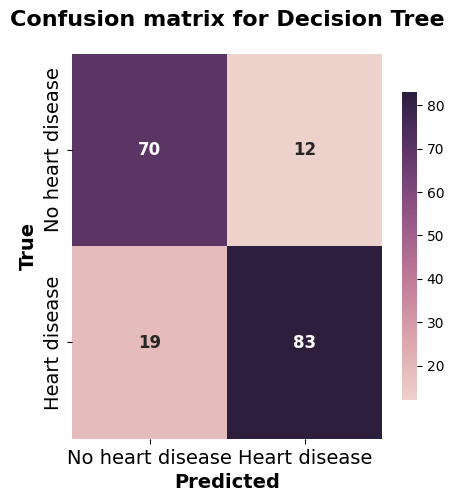

Most confusing classes: True label 1 --> predicted as 0


In [16]:
best_model.fit(X_train, y_train)
decision_tree_eval = ModelEvaluator(best_model,"Decision Tree",color_theme=sns.cubehelix_palette(as_cmap=True))
decision_tree_eval.summarize(X_test, y_test)

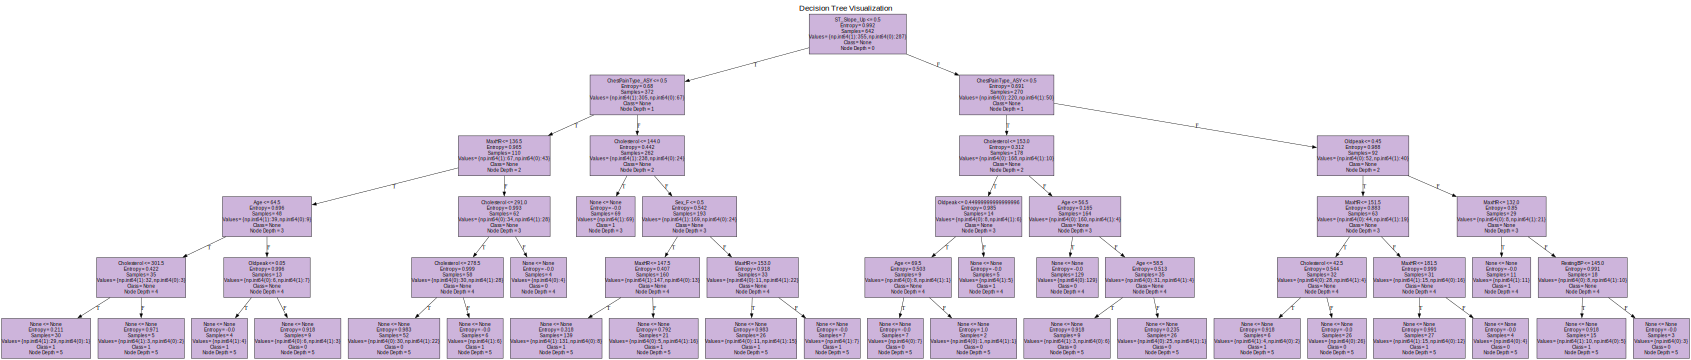

In [17]:
dot = Digraph()
dot.attr(size="25,5")
dot.attr(label="Decision Tree Visualization", labelloc="t", fontsize="20", fontname="Arial")
dot.attr("node", shape="box", width="0", height="0", margin="0.1", style="filled", fillcolor="#cdb4db", fontname="Arial", fontsize="12")
plot_tree(best_model, dot)

## Bagging

In [18]:
class Bagging_Classifier:
    def train_single_model(self, m):
            X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=m)
            decision_tree_model = DecisionTreeClassifier()
            decision_tree_model.fit(X_resampled, y_resampled)
            return decision_tree_model

    def validate_bagging_model(self, m_models):
        y_m_model = []
        y_bagging = []

        for i in range(0, len(m_models)):
            y_m_model.append(m_models[i].predict(X_val))
        
        y_maj_vote = [sum(col) / len(col) for col in zip(*y_m_model)]
        for i in range(0, len(y_maj_vote)):
            if(y_maj_vote[i] > 0.5): y_bagging.append(1)
            else: y_bagging.append(0)

        accuracy = accuracy_score(y_val,y_bagging)
        return accuracy

In [19]:
best_m = 1
best_accuracy = 0
best_models = []
Bagging_classifier = Bagging_Classifier()
m_models = []
for m in range(1, 31):
    m_models.append(Bagging_classifier.train_single_model(m))
    accuracy = Bagging_classifier.validate_bagging_model(m_models)
    if(accuracy > best_accuracy):
        best_accuracy = accuracy
        best_m = m
        best_models = m_models

print(f"Best_M_According_to_Validation: {best_m}")
print(f"Best_Accuracy: {best_accuracy}\n")

Best_M_According_to_Validation: 6
Best_Accuracy: 0.8913043478260869



Model Bagging
Accuracy 0.8695652173913043
F1-score: 0.8811881188118812

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.85      0.87      0.86        82
   Heart disease       0.89      0.87      0.88       102

        accuracy                           0.87       184
       macro avg       0.87      0.87      0.87       184
    weighted avg       0.87      0.87      0.87       184



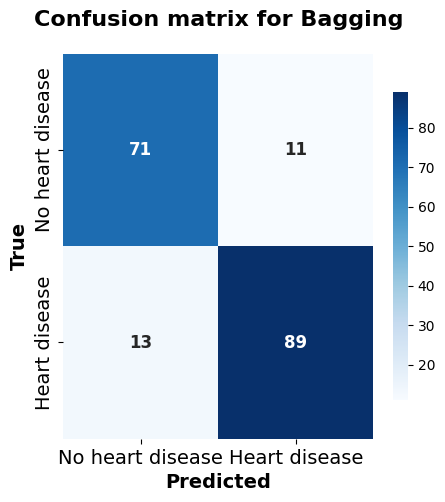

Most confusing classes: True label 1 --> predicted as 0


In [20]:
# Evaluation
bagging_eval = ModelEvaluator(best_models,"Bagging")
bagging_eval.summarize_bagging(X_test, y_test)

## AdaBoost

### Decision Stump

In [21]:
class DecisionStump:
    def __init__(self):
        self.feature = None
        self.threshold = None
        self.below_threshold_class = None
        self.above_threshold_class = None
        
    def fit(self, X, y, sample_weights):
        _, features = X.shape
        best_err = float('inf')

        # finding the best feature and threshold to split on
        for f in range(features):
            thresholds = np.unique(X.iloc[:, f])
            for threshold in thresholds:
                below_threshold = X.iloc[:, f] <= threshold
                above_threshold = X.iloc[:, f] > threshold
                
                # calculating weighted sums for each class in the below-threshold subset
                below_class_0_weighted = np.sum(sample_weights[below_threshold] * (y[below_threshold] == -1))
                below_class_1_weighted = np.sum(sample_weights[below_threshold] * (y[below_threshold] == 1))

                # assign the majority class for the below-threshold subset
                below_class = -1 if below_class_0_weighted > below_class_1_weighted else 1

                # calculating weighted sums for each class in the above-threshold subset
                above_class_0_weighted = np.sum(sample_weights[above_threshold] * (y[above_threshold] == -1))
                above_class_1_weighted = np.sum(sample_weights[above_threshold] * (y[above_threshold] == 1))

                # assign the majority class for the above-threshold subset
                above_class = 1 if above_class_1_weighted > above_class_0_weighted else -1

                # compute weighted error
                below_err = np.sum(sample_weights[below_threshold] * (y[below_threshold] != below_class))
                above_err = np.sum(sample_weights[above_threshold] * (y[above_threshold] != above_class))
                
                total_err = below_err + above_err
                
                # if this split is better update parameters
                if total_err < best_err:
                    best_err = total_err
                    self.feature = f
                    self.threshold = threshold
                    self.below_threshold_class = below_class
                    self.above_threshold_class = above_class
        
    def predict(self, X):
        # extract the relevant feature column
        feature_column = X.iloc[:, self.feature]

        # create a boolean mask for values below or equal to the threshold
        below_threshold_mask = feature_column <= self.threshold

        predictions = np.zeros(X.shape[0])

        # assign class labels based on the threshold comparison
        predictions[below_threshold_mask] = self.below_threshold_class
        predictions[~below_threshold_mask] = self.above_threshold_class

        return predictions

### Build the model

In [22]:

class AdaBoost:
    def __init__(self, num_weak_learners=50):
        self.num_weak_learners = num_weak_learners
        self.weak_learners = []
        
    def fit(self, X, y):
        samples_num = X.shape[0]
        sample_weights = np.ones(samples_num) / samples_num  # Initailly all samples are equally weighted where w = 1/samples_num
        
        for _ in range(self.num_weak_learners):
            stump = DecisionStump()
            stump.fit(X, y, sample_weights)
            predictions = stump.predict(X)
            
            # computing the weighted error
            err = np.sum(sample_weights * (predictions != y)) / np.sum(sample_weights)

            # compute alpha using error
            stump.alpha = 0.5 * np.log((1 - err) / (err + 1e-10))  # 1e-10 to avoid dividing by zero
            
            # updating the weights of samples
            sample_weights *= np.exp(-stump.alpha * y * predictions)
            # Normalization
            sample_weights /= np.sum(sample_weights)  
            
            self.weak_learners.append(stump)

    def predict(self, X):
        # combine weak learners' weighted predictions
        final_predictions = np.zeros(X.shape[0])
        for stump in self.weak_learners:
            final_predictions += stump.alpha * stump.predict(X)
        return np.sign(final_predictions)



### Tuning AdaBoost hyperameters Weak learners

In [23]:
import numpy as np

def compute_exponential_loss(y_true, weak_learners, sample_weights, X_val):
    final_predictions = np.zeros_like(y_true, dtype=float)

    # sum weighted predictions
    for stump in weak_learners:
        final_predictions += stump.alpha * stump.predict(X_val)
        
    # L = sum(w_i * exp(-y_i * F(x_i)))
    loss = np.sum(sample_weights * np.exp(-y_true * final_predictions))
    return loss


def tune_hyperparameters(X_train, y_train, X_val, y_val, learners_num):
    max_t = max(learners_num)  # train once with max weak learners
    model = AdaBoost(num_weak_learners=max_t)  
    model.fit(X_train, y_train)  # train once

    best_num = None
    best_accuracy = 0
    best_loss = float("inf")  

    for t in learners_num:
        # use first t weak learners instead of retraining
        sub_weak_learners = model.weak_learners[:t]
        
        # compute predictions using only the first t weak learners
        final_predictions = np.zeros_like(y_val, dtype=float)
        for stump in sub_weak_learners:
            final_predictions += stump.alpha * stump.predict(X_val)
        
        y_val_pred = np.sign(final_predictions)

        # compute accuracy
        accuracy = np.mean(y_val_pred == y_val)

        # compute exponential loss
        sample_weights = np.ones(len(y_val)) / len(y_val)  
        loss = np.sum(sample_weights * np.exp(-y_val * final_predictions))

        print(f"Weak learners_num = {t} | Validation Accuracy: {accuracy:.4f} | Exponential Loss: {loss:.4f}")

        # select the best model based on minimum loss then accuracy
        if loss < best_loss or (loss == best_loss and accuracy > best_accuracy):
            best_loss = loss
            best_accuracy = accuracy
            best_num = t

    print(f"\nBest number of weak learners: {best_num} | Accuracy: {best_accuracy:.4f} | Exponential Loss: {best_loss:.4f}")
    return best_num


In [24]:
# find the best number of weak learners
# create copies of the labels to avoid modifying the original data
y_train_mod = y_train.copy()
y_val_mod = y_val.copy()

# convert labels: change 0 to -1 for adaboost 
y_train_mod[y_train_mod == 0] = -1
y_val_mod[y_val_mod == 0] = -1

best_n_estimators = tune_hyperparameters(X_train, y_train_mod, X_val, y_val_mod, learners_num=[5, 10, 20, 30, 50])

Weak learners_num = 5 | Validation Accuracy: 0.8587 | Exponential Loss: 0.5532
Weak learners_num = 10 | Validation Accuracy: 0.8913 | Exponential Loss: 0.5232
Weak learners_num = 20 | Validation Accuracy: 0.8913 | Exponential Loss: 0.5314
Weak learners_num = 30 | Validation Accuracy: 0.8913 | Exponential Loss: 0.5361
Weak learners_num = 50 | Validation Accuracy: 0.9022 | Exponential Loss: 0.5274

Best number of weak learners: 10 | Accuracy: 0.8913 | Exponential Loss: 0.5232


In [25]:
# train adaboost model
adaboost_model = AdaBoost(num_weak_learners=best_n_estimators)
adaboost_model.fit(X_train, y_train_mod)

Model AdaBoost
Accuracy 0.8641304347826086
F1-score: 0.8743718592964824

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.83      0.88      0.85        82
   Heart disease       0.90      0.85      0.87       102

        accuracy                           0.86       184
       macro avg       0.86      0.87      0.86       184
    weighted avg       0.87      0.86      0.86       184



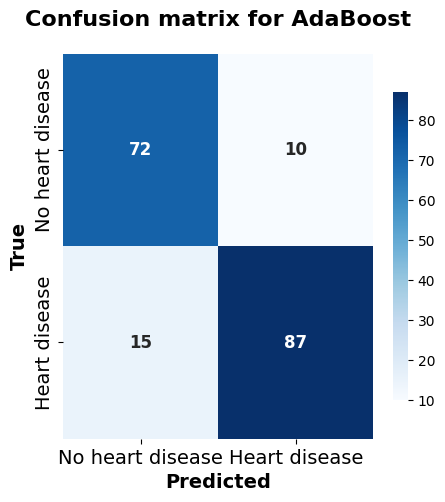

Most confusing classes: True label 1 --> predicted as 0


In [26]:
# evaluate the model
evaluator = ModelEvaluator(adaboost_model, model_name="AdaBoost", color_theme="Blues")
evaluator.summarize(X_test, y_test)

## Logistic Regression

## KNN

In [27]:
class KNN_Classifier:
    def train_knn_model(self, n_neighbors):
        knn = KNeighborsClassifier(n_neighbors)
        knn.fit(data_processor.standardize_features(X_train), y_train)
        return knn
    
    def validate_knn_model(self, knn):
        y_pred = knn.predict(data_processor.standardize_features(X_val))
        accuracy = accuracy_score(y_val,y_pred)
        return accuracy

Best_K_According_to_Validation: 19
Best_Accuracy: 0.9456521739130435

Model KNN
Accuracy 0.8858695652173914
F1-score: 0.896551724137931

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.87      0.88      0.87        82
   Heart disease       0.90      0.89      0.90       102

        accuracy                           0.89       184
       macro avg       0.88      0.89      0.88       184
    weighted avg       0.89      0.89      0.89       184



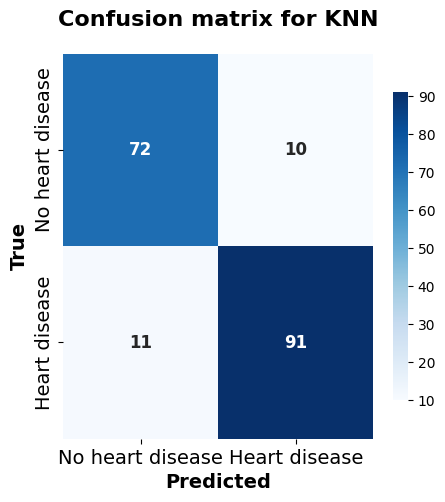

Most confusing classes: True label 1 --> predicted as 0


In [28]:
best_k = 1
best_accuracy = 0
knn_classifier = KNN_Classifier()
for k in range(1, 31):
    knn = knn_classifier.train_knn_model(k)
    accuracy = knn_classifier.validate_knn_model(knn)
    if(accuracy > best_accuracy):
        best_accuracy = accuracy
        best_k = k

print(f"Best_K_According_to_Validation: {best_k}")
print(f"Best_Accuracy: {best_accuracy}\n")
    
best_knn = knn_classifier.train_knn_model(best_k)
knn_eval = ModelEvaluator(best_knn,"KNN")
knn_eval.summarize(data_processor.standardize_features(X_test), y_test)

## FNN

### Training callbacks 

In [29]:
class TrainingCallbacks:
    def __init__(self, early_stopping_patience=20, reduce_lr_patience=3,
                  reduce_lr_factor=0.2, min_lr=1e-5):
        self.early_stopping_patience = early_stopping_patience
        self.reduce_lr_patience = reduce_lr_patience
        self.reduce_lr_factor = reduce_lr_factor
        self.min_lr = min_lr

    def get_callbacks(self):
        # Early stopping callbacks
        es = callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=self.early_stopping_patience, # Stopping after certain number of epochs with no improvement
            verbose=1,
            mode='max', # because we want to maximize the validation accuracy
            restore_best_weights=True

        )

        # Learning rate reduction callbacks
        rp = callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=self.reduce_lr_factor, 
            patience=self.reduce_lr_patience, # wait for certain number of epochs before lr reduction
            verbose=1,
            mode="max",
            min_lr=self.min_lr
        )

        return [es, rp]

### Build the model

In [30]:
class FeedforwardNeuralNetwork:
    def __init__(self, input_size, hidden_neurons = 16, learning_rate = 0.001):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        # Input layer
        model.add(InputLayer(shape=(self.input_size,)))
        # Hidden layer
        model.add(Dense(self.hidden_neurons, activation='relu'))
        # Output layer
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, callbacks=None):
        history = self.model.fit(
            X_train, y_train,
            epochs = epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        return history
    
    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test,verbose=0)
        print("Test loss:",loss)
        print("Test accuracy:",accuracy)
        return loss,accuracy
    
    def predict(self,X):
        return self.model.predict(X)

In [31]:
# Initializing FNN
input_size = X_train.shape[1]
fnn_model = FeedforwardNeuralNetwork(input_size=input_size,hidden_neurons=16,learning_rate=0.001)

# Setting up training callbacks
training_callbacks = TrainingCallbacks(
    early_stopping_patience=20,
    reduce_lr_patience=20,
    reduce_lr_factor=0.2,
    min_lr=1e-5
)
callbacks_list = training_callbacks.get_callbacks()

# Train the model
history = fnn_model.train(
    X_train,y_train,
    X_val,y_val,
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5130 - loss: 12.3267 - val_accuracy: 0.5326 - val_loss: 7.3937 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4876 - loss: 5.7873 - val_accuracy: 0.5326 - val_loss: 5.7356 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4866 - loss: 3.7972 - val_accuracy: 0.6304 - val_loss: 1.7845 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6564 - loss: 1.5268 - val_accuracy: 0.7174 - val_loss: 1.3679 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7450 - loss: 1.2191 - val_accuracy: 0.7283 - val_loss: 1.1089 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7153 - loss: 1.0544 - val_accuracy: 0.7391 - val_loss: 1.0048 - learning_rate: 0.0010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7375 - loss: 0.8463 - val_accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model FNN
Accuracy 0.8695652173913043
F1-score: 0.88

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.84      0.88      0.86        82
   Heart disease       0.90      0.86      0.88       102

        accuracy                           0.87       184
       macro avg       0.87      0.87      0.87       184
    weighted avg       0.87      0.87      0.87       184



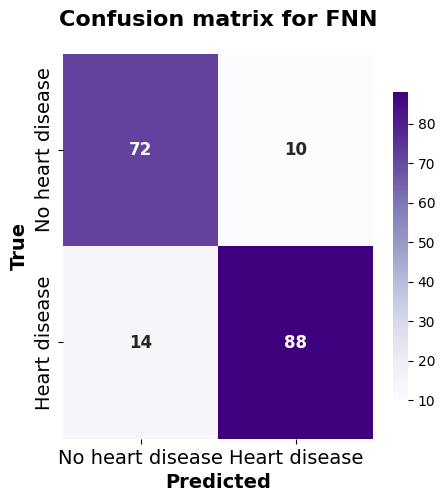

Most confusing classes: True label 1 --> predicted as 0


In [32]:
# Evaluate the model
fnn_evaluator = ModelEvaluator(fnn_model,"FNN",color_theme="Purples")
fnn_evaluator.summarize(X_test,y_test)

In [33]:
# Make predictions on the test set
predictions = fnn_model.predict(X_test)

results = pd.DataFrame({
    'Actual':y_test,
    'Predicted':predictions.flatten(),
    'Probability':predictions.flatten()
})

# Printing the results of predictions
print("Predictions vs Actual Labels:")
print("-" * 30)
print(results.head(10))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Predictions vs Actual Labels:
------------------------------
     Actual  Predicted  Probability
652       1   0.083893     0.083893
117       1   0.691906     0.691906
800       0   0.090730     0.090730
274       0   0.010165     0.010165
669       0   0.087227     0.087227
488       0   0.094363     0.094363
12        0   0.038578     0.038578
605       0   0.298767     0.298767
212       0   0.263583     0.263583
709       1   0.184392     0.184392


# Analysis and Comparison